# Leverage deployment guardrails to update a SageMaker Inference endpoint using canary traffic shifting



# Contents

 - [Introduction](#Introduction)
 - [Setup](#Setup)
 - [Step 1: Create and deploy the pre-trained models](#Step1)
 - [Step 2: Invoke Endpoint](#Step2)
 - [Step 3: Create CloudWatch alarms to monitor Endpoint performance](#Step3)
 - [Step 4: Update Endpoint with deployment configurations- Canary Traffic Shifting](#Step4)
 - [Cleanup](#Clenup)

# Introduction <a id='Introduction'></a>

Deployment guardrails are a set of model deployment options in Amazon SageMaker Inference to update your machine learning models in production. Using the fully managed deployment guardrails, you can control the switch from the current model in production to a new one. Traffic shifting modes, such as canary and linear, give you granular control over the traffic shifting process from your current model to the new one during the course of the update. There are also built-in safeguards such as auto-rollbacks that help you catch issues early and take corrective action before they impact production.

We support blue-green deployment with multiple traffic shifting modes. A traffic shifting mode is a configuration that specifies how endpoint traffic is routed to a new fleet containing your updates. The following traffic shifting modes provide you with different levels of control over the endpoint update process:

* **All-At-Once Traffic Shifting** : shifts all of your endpoint traffic from the blue fleet to the green fleet. Once the traffic has shifted to the green fleet, your pre-specified Amazon CloudWatch alarms begin monitoring the green fleet for a set amount of time (the “baking period”). If no alarms are triggered during the baking period, then the blue fleet is terminated.
* **Canary Traffic Shifting** : lets you shift one small portion of your traffic (a “canary”) to the green fleet and monitor it for a baking period. If the canary succeeds on the green fleet, then the rest of the traffic is shifted from the blue fleet to the green fleet before terminating the blue fleet.
* **Linear Traffic Shifting** : provides even more customization over how many traffic-shifting steps to make and what percentage of traffic to shift for each step. While canary shifting lets you shift traffic in two steps, linear shifting extends this to n number of linearly spaced steps.


The Deployment guardrails for Amazon SageMaker Inference endpoints feature also allows customers to specify conditions/alarms based on Endpoint invocation metrics from CloudWatch to detect model performance regressions and trigger automatic rollback.

In this notebook we'll update endpoint with following deployment configurations:
 * Blue/Green update policy with **Canary traffic shifting option**
 * Configure CloudWatch alarms to monitor model performance and trigger auto-rollback action.
  
To demonstrate Canary deployments and the auto-rollback feature, we will update an Endpoint with an incompatible model version and deploy it as a Canary fleet, taking a small percentage of the traffic. Requests sent to this Canary fleet will result in errors, which will be used to trigger a rollback using pre-specified CloudWatch alarms. Finally, we will also demonstrate a success scenario where no alarms are tripped and the update succeeds. 

This notebook is organized in 4 steps -
* Step 1 creates the models and Endpoint Configurations required for the 3 scenarios - the baseline, the update containing the incompatible model version and the update containing the correct model version. 
* Step 2 invokes the baseline Endpoint prior to the update. 
* Step 3 specifies the CloudWatch alarms used to trigger the rollbacks. 
* Finally in step 4, we update the endpoint to trigger a rollback and demonstrate a successful update. 

# Setup <a id='Setup'></a>

Ensure that you have an updated version of boto3, which includes the latest SageMaker features:

In [2]:
!pip install -U awscli
!pip install sagemaker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 124.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 183.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.5/570.5 kB 57.1 MB/s eta 0:00:00
  Attempting uninstall: docutils
    Found existing installation: docutils 0.16
    Uninstalling docutils-0.16:
      Successfully uninstalled docutils-0.16
  Attempting uninstall: botocore
    Found existing installation: botocore 1.37.22
    Uninstalling botocore-1.37.22:
      Successfully uninstalled botocore-1.37.22
  Attempting uninstall: awscli
    Found existing installation: awscli 1.38.22
    Uninstalling awscli-1.38.22:
      Successfully uninstalled awscli-1.38.22
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
sphinx 8.1.3 requires docutils<0.22,>=0.20, but you have docutils 0.19 which is incompatible.
sphinx 8.1.

Setup some required imports and basic initial variables:

In [3]:
%matplotlib inline

import time
import os
import boto3
import botocore
import re
import json
from datetime import datetime, timedelta, timezone
from sagemaker import get_execution_role, session
from sagemaker.s3 import S3Downloader, S3Uploader

region = boto3.Session().region_name

# You can use a different IAM role with "SageMakerFullAccess" policy for this notebook
role = get_execution_role()
print(f"Execution role: {role}")

sm_session = session.Session(boto3.Session())
sm = boto3.Session().client("sagemaker")
sm_runtime = boto3.Session().client("sagemaker-runtime")

# You can use a different bucket, but make sure the role you chose for this notebook
# has the s3:PutObject permissions. This is the bucket into which the model artifacts will be uploaded
bucket = "final-project-drk"
prefix = "sagemaker/RealTime-Weather-Deployment-Guardrails-Canary"

Matplotlib is building the font cache; this may take a moment.
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pydantic/_internal/_fields.py:198: UserWarning: Field name "json" in "MonitoringDatasetFormat" shadows an attribute in parent "Base"
  warnings.warn(


[04/19/25 20:50:07] INFO     Found credentials from IAM Role:                                   ]8;id=746419;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=238901;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


[04/19/25 20:50:08] INFO     Found credentials from IAM Role:                                   ]8;id=173126;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=983943;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Execution role: arn:aws:iam::796225939623:role/LabRole


[04/19/25 20:50:09] INFO     Found credentials from IAM Role:                                   ]8;id=963669;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=598108;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=269779;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=679142;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=34755;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=731873;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Download the Input files and pre-trained model from S3 bucket

In [4]:
# s3://final-project-drk/sagemaker-sample-files-drk/models/linear-learner-weather/005-model.tar.gz
# s3://final-project-drk/sagemaker-sample-files-drk/models/linear-learner-weather/009-model.tar.gz
!aws s3 cp s3://{bucket}/sagemaker-sample-files-drk/models/linear-learner-weather/005-model.tar.gz model/
!aws s3 cp s3://{bucket}/sagemaker-sample-files-drk/models/linear-learner-weather/009-model.tar.gz model/

# s3://final-project-drk/sagemaker-sample-files-drk/datasets/test_linear_input_cols.csv
# s3://final-project-drk/sagemaker-sample-files-drk/datasets/test_linear.csv
!aws s3 cp s3://{bucket}/sagemaker-sample-files-drk/datasets/test_linear.csv test_data/
!aws s3 cp s3://{bucket}/sagemaker-sample-files-drk/datasets/test_linear_input_cols.csv test_data/

download: s3://final-project-drk/sagemaker-sample-files-drk/models/linear-learner-weather/005-model.tar.gz to model/005-model.tar.gz
download: s3://final-project-drk/sagemaker-sample-files-drk/models/linear-learner-weather/009-model.tar.gz to model/009-model.tar.gz
download: s3://final-project-drk/sagemaker-sample-files-drk/datasets/test_linear.csv to test_data/test_linear.csv
download: s3://final-project-drk/sagemaker-sample-files-drk/datasets/test_linear_input_cols.csv to test_data/test_linear_input_cols.csv


# Model vs Multiclass Accuracy

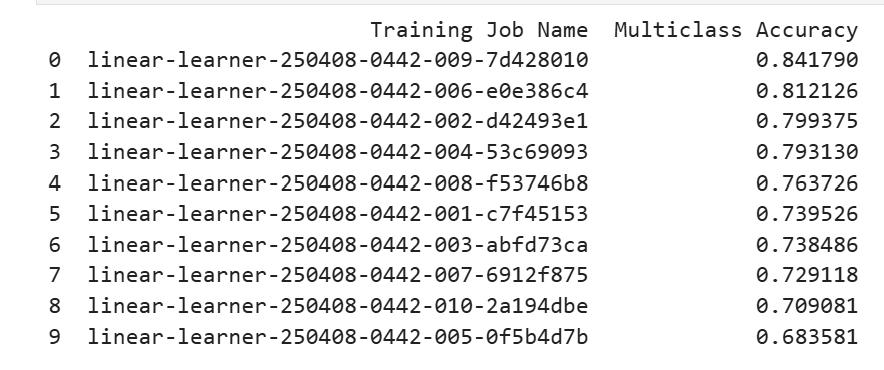

## Model Selection
#### Version-1 : 005 model (linear-learner-250408-0442-005-0f5b4d7b  Accuracy: 68.3% )
#### Version-2 : 009 model (linear-learner-250408-0442-009-7d428010  Accuracy: 84.1%)

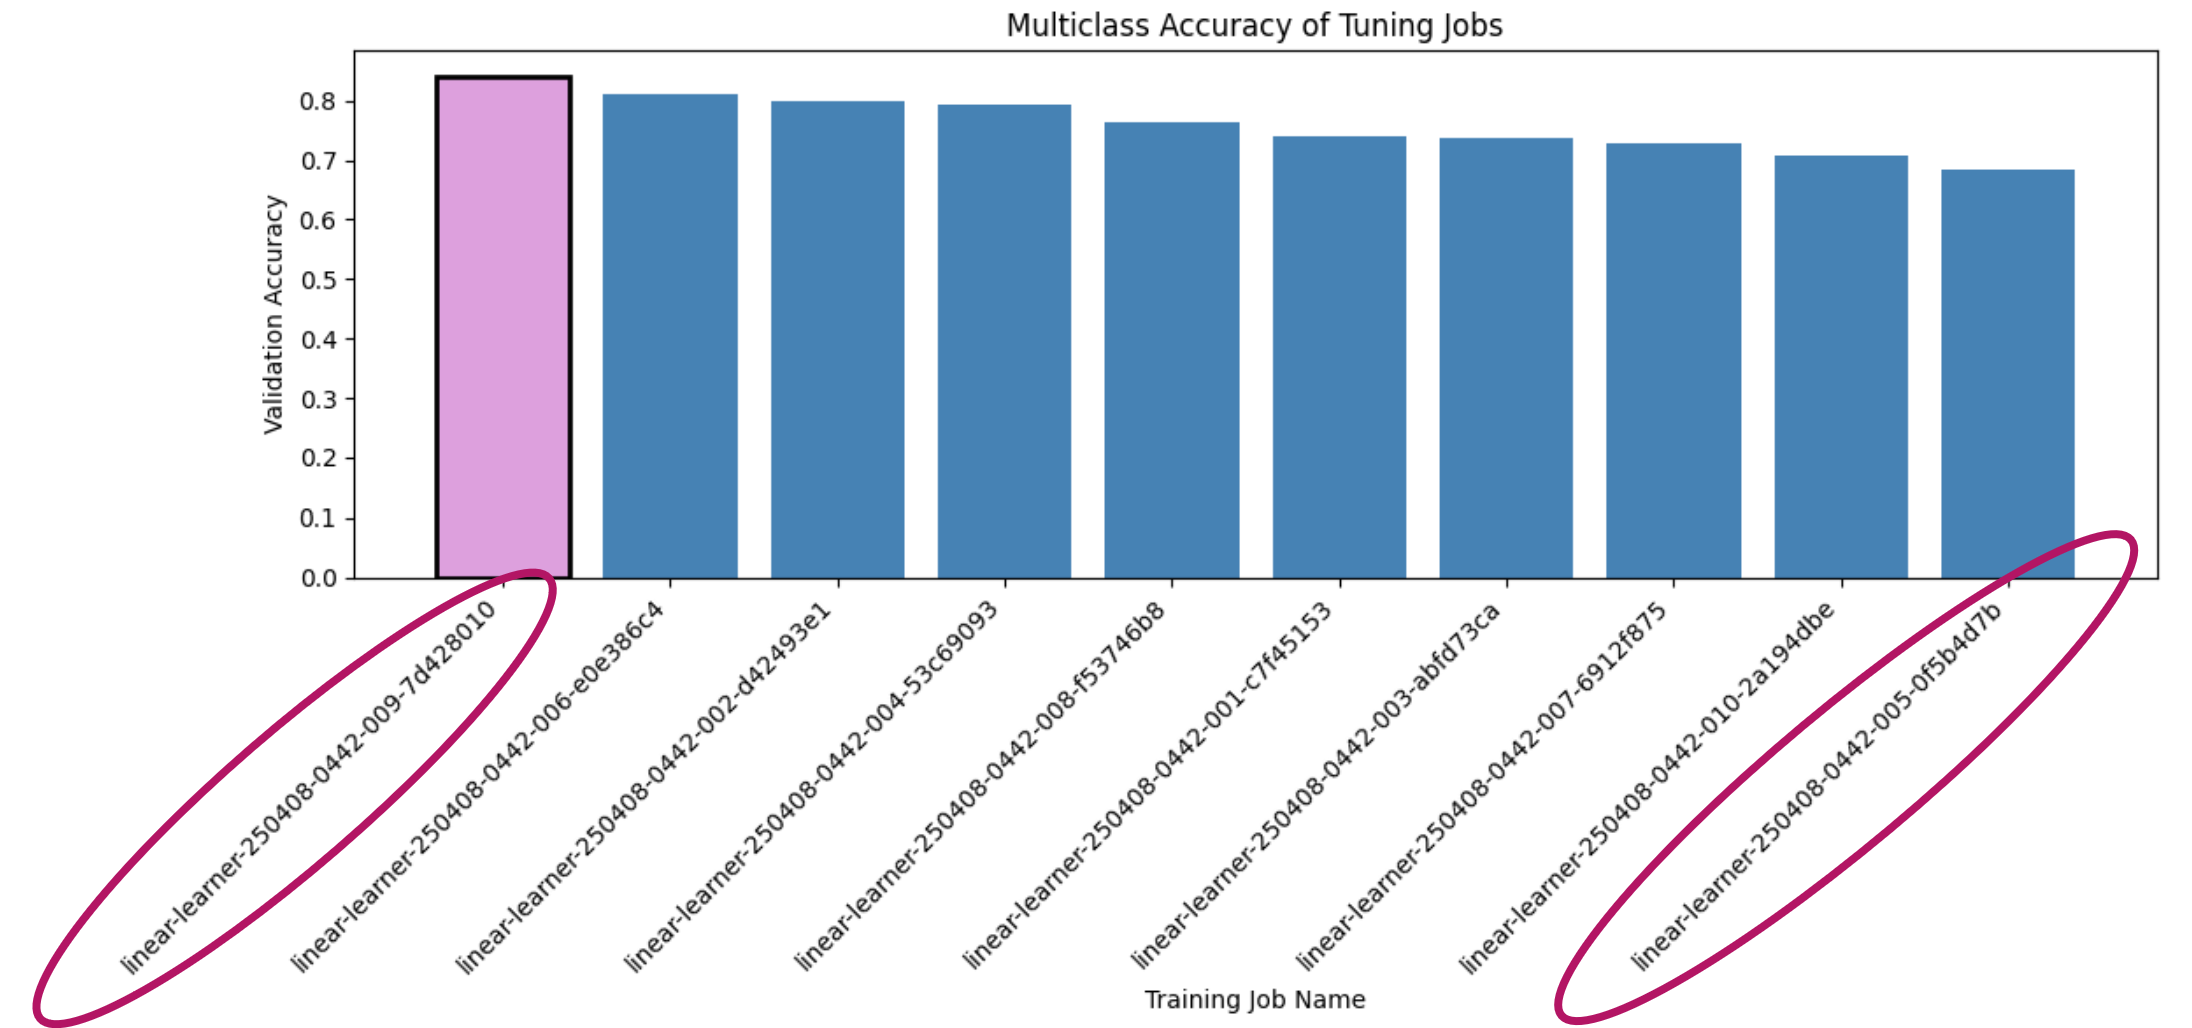

# Step 1: Create and deploy the models <a id='Step1'></a>

### First, we upload our pre-trained models to Amazon S3
This code uploads two pre-trained XGBoost models that are ready for you to deploy. These models were trained using the [XGB Churn Prediction Notebook](https://github.com/aws/amazon-sagemaker-examples/blob/master/introduction_to_applying_machine_learning/xgboost_customer_churn/xgboost_customer_churn.ipynb) in SageMaker. You can also use your own pre-trained models in this step. If you already have a pretrained model in Amazon S3, you can add it by specifying the s3_key.

The models in this example are used to predict the probability of a mobile customer leaving their current mobile operator. The dataset we use is publicly available and was mentioned in the book [Discovering Knowledge in Data](https://www.amazon.com/dp/0470908742/) by Daniel T. Larose. It is attributed by the author to the University of California Irvine Repository of Machine Learning Datasets.

In [5]:
model_url = S3Uploader.upload(
    local_path="model/005-model.tar.gz",
    desired_s3_uri=f"s3://{bucket}/{prefix}",
)
model_url2 = S3Uploader.upload(
    local_path="model/009-model.tar.gz",
    desired_s3_uri=f"s3://{bucket}/{prefix}",
)

print(f"Model URI 1: {model_url}")
print(f"Model URI 2: {model_url2}")

[04/19/25 20:50:37] INFO     Found credentials from IAM Role:                                   ]8;id=561088;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=384968;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=347096;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=134321;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

Model URI 1: s3://final-project-drk/sagemaker/RealTime-Weather-Deployment-Guardrails-Canary/005-model.tar.gz
Model URI 2: s3://final-project-drk/sagemaker/RealTime-Weather-Deployment-Guardrails-Canary/009-model.tar.gz


## ------------------------------------
## RealTime Deployment
## ------------------------------------

In [6]:
from sagemaker import image_uris

# Retrieve Linear Learner image URIs independently for each model config
image_uri1 = image_uris.retrieve(
    framework="linear-learner",
    region=boto3.Session().region_name
)

image_uri2 = image_uris.retrieve(
    framework="linear-learner",
    region=boto3.Session().region_name
)

image_uri3 = image_uris.retrieve(
    framework="linear-learner",
    region=boto3.Session().region_name
)

print(f"Model Image 1 (Linear Learner): {image_uri1}")
print(f"Model Image 2 (Linear Learner): {image_uri2}")
print(f"Model Image 3 (Linear Learner): {image_uri3}")


[04/19/25 20:51:02] INFO     Same images used for training and inference. Defaulting to image     ]8;id=218221;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=342105;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=834225;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=253722;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=561189;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=948141;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=467949;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=820627;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=65441;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=807901;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=997951;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=146266;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

Model Image 1 (Linear Learner): 382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1
Model Image 2 (Linear Learner): 382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1
Model Image 3 (Linear Learner): 382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1


In [7]:
from datetime import datetime

# Custom model names (aligned to real-time V1 configs)
model_name1 = f"weather-model-v1-005-1-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name2 = f"weather-model-v1-005-2-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name3 = f"weather-model-v1-005-3-{datetime.now():%Y-%m-%d-%H-%M-%S}"

print(f"Model Name 1: {model_name1}")
print(f"Model Name 2: {model_name2}")
print(f"Model Name 3: {model_name3}")

# Create Model 1 (Real-time config 1)
resp1 = sm.create_model(
    ModelName=model_name1,
    ExecutionRoleArn=role,
    Containers=[{
        "Image": image_uri1,
        "ModelDataUrl": model_url,
    }]
)
print(f"✅ Created Model 1: {resp1['ModelArn']}")

# Create Model 2 (Real-time config 2)
resp2 = sm.create_model(
    ModelName=model_name2,
    ExecutionRoleArn=role,
    Containers=[{
        "Image": image_uri2,
        "ModelDataUrl": model_url,
    }]
)
print(f"✅ Created Model 2: {resp2['ModelArn']}")

# Create Model 3 (Real-time config 3)
resp3 = sm.create_model(
    ModelName=model_name3,
    ExecutionRoleArn=role,
    Containers=[{
        "Image": image_uri3,
        "ModelDataUrl": model_url,
    }]
)
print(f"✅ Created Model 3: {resp3['ModelArn']}")

Model Name 1: weather-model-v1-005-1-2025-04-19-20-51-24
Model Name 2: weather-model-v1-005-2-2025-04-19-20-51-24
Model Name 3: weather-model-v1-005-3-2025-04-19-20-51-24
✅ Created Model 1: arn:aws:sagemaker:us-east-1:796225939623:model/weather-model-v1-005-1-2025-04-19-20-51-24
✅ Created Model 2: arn:aws:sagemaker:us-east-1:796225939623:model/weather-model-v1-005-2-2025-04-19-20-51-24
✅ Created Model 3: arn:aws:sagemaker:us-east-1:796225939623:model/weather-model-v1-005-3-2025-04-19-20-51-24


In [8]:
from datetime import datetime
import time

# Endpoint config names for each rollout version
ep_config_name1 = f"weather-config-v1-005-1-{datetime.now():%Y-%m-%d-%H-%M-%S}"
ep_config_name2 = f"weather-config-v1-005-2-{datetime.now():%Y-%m-%d-%H-%M-%S}"
ep_config_name3 = f"weather-config-v1-005-3-{datetime.now():%Y-%m-%d-%H-%M-%S}"

print(f"Endpoint Config 1: {ep_config_name1}")
print(f"Endpoint Config 2: {ep_config_name2}")
print(f"Endpoint Config 3: {ep_config_name3}")

# Endpoint Config 1
resp1 = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name1,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name1,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 3,
        }
    ],
)
print(f"✅ Created Endpoint Config 1: {resp1}")
time.sleep(5)

# Endpoint Config 2
resp2 = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name2,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name2,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 3,
        }
    ],
)
print(f"✅ Created Endpoint Config 2: {resp2}")
time.sleep(5)

# Endpoint Config 3
resp3 = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name3,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name3,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 3,
        }
    ],
)
print(f"✅ Created Endpoint Config 3: {resp3}")
time.sleep(5)

Endpoint Config 1: weather-config-v1-005-1-2025-04-19-20-51-37
Endpoint Config 2: weather-config-v1-005-2-2025-04-19-20-51-37
Endpoint Config 3: weather-config-v1-005-3-2025-04-19-20-51-37
✅ Created Endpoint Config 1: {'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:796225939623:endpoint-config/weather-config-v1-005-1-2025-04-19-20-51-37', 'ResponseMetadata': {'RequestId': 'f5232b88-337e-4f50-84e3-351a93e14ef4', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'f5232b88-337e-4f50-84e3-351a93e14ef4', 'content-type': 'application/x-amz-json-1.1', 'content-length': '124', 'date': 'Sat, 19 Apr 2025 20:51:37 GMT'}, 'RetryAttempts': 0}}
✅ Created Endpoint Config 2: {'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:796225939623:endpoint-config/weather-config-v1-005-2-2025-04-19-20-51-37', 'ResponseMetadata': {'RequestId': 'a06eea61-23cf-4023-8fad-7f5ec0dc4a85', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'a06eea61-23cf-4023-8fad-7f5ec0dc4a85', 'content-type': 'appl

In [9]:
from datetime import datetime

# Properly format the timestamp using an f-string
endpoint_name = f"weather-prediction-endpoint-{datetime.now():%Y-%m-%d-%H-%M-%S}"
print(f"Endpoint Name: {endpoint_name}")

# Deploy using the first (stable) endpoint config
resp = sm.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=ep_config_name1
)

print(f"\n✅ Created Endpoint: {resp['EndpointArn']}")

Endpoint Name: weather-prediction-endpoint-2025-04-19-20-51-56

✅ Created Endpoint: arn:aws:sagemaker:us-east-1:796225939623:endpoint/weather-prediction-endpoint-2025-04-19-20-51-56


In [10]:
import time

def wait_for_endpoint_in_service(endpoint_name):
    print(f"🔄 Waiting for endpoint '{endpoint_name}' to reach 'InService' status...")

    while True:
        details = sm.describe_endpoint(EndpointName=endpoint_name)
        status = details["EndpointStatus"]
        print(f"Current status: {status}")

        if status == "InService":
            print("✅ Endpoint is InService and ready for inference!")
            break
        elif status == "Failed":
            print("❌ Endpoint deployment failed. Please check logs in CloudWatch.")
            break

        time.sleep(30)

# Call the wait function
wait_for_endpoint_in_service(endpoint_name)

# Display final endpoint metadata
endpoint_desc = sm.describe_endpoint(EndpointName=endpoint_name)

🔄 Waiting for endpoint 'weather-prediction-endpoint-2025-04-19-20-51-56' to reach 'InService' status...
Current status: Creating
Current status: Creating
Current status: Creating
Current status: Creating
Current status: Creating
Current status: Creating
Current status: Creating
Current status: Creating
Current status: Creating
Current status: Creating
Current status: InService
✅ Endpoint is InService and ready for inference!


In [11]:
endpoint_desc

{'EndpointName': 'weather-prediction-endpoint-2025-04-19-20-51-56',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:796225939623:endpoint/weather-prediction-endpoint-2025-04-19-20-51-56',
 'EndpointConfigName': 'weather-config-v1-005-1-2025-04-19-20-51-37',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1',
     'ResolvedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner@sha256:2e3a9eeeb8246b7f2a0438e39457ffce204e200676693566b021e31c9291cb68',
     'ResolutionTime': datetime.datetime(2025, 4, 19, 20, 51, 57, 394000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'InService',
 'CreationTime': datetime.datetime(2025, 4, 19, 20, 51, 56, 550000, tzinfo=tzlocal()),
 'LastModifiedTime': datetime.datetime(2025, 4, 19, 20, 56, 41, 987000, tzinfo=tzlocal()),
 'ResponseM

## Invoke Endpoints

In [12]:
def invoke_endpoint(
    endpoint_name, max_invocations=600, wait_interval_sec=1, should_raise_exp=False
):
    print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

    count = 0
    with open("test_data/test_linear_input_cols.csv", "r") as f:
        for row in f:
            payload = row.rstrip("\n")
            try:
                response = sm_runtime.invoke_endpoint(
                    EndpointName=endpoint_name,
                    ContentType="text/csv",
                    Body=payload
                )
                response["Body"].read()
                print(".", end="", flush=True)
            except Exception as e:
                print("E", end="", flush=True)
                if should_raise_exp:
                    raise e

            count += 1
            if count > max_invocations:
                break

            time.sleep(wait_interval_sec)

    print("\nDone!")

# Trigger with 100 requests
invoke_endpoint(endpoint_name, max_invocations=100)

Sending test traffic to the endpoint weather-prediction-endpoint-2025-04-19-20-51-56. 
Please wait...
.....................................................................................................
Done!


## Invocation Metrics

In [13]:
import pandas as pd
from datetime import datetime, timedelta, timezone

cw = boto3.Session().client("cloudwatch", region_name=region)

def get_sagemaker_metrics(
    endpoint_name,
    endpoint_config_name,
    variant_name,
    metric_name,
    statistic,
    start_time,
    end_time,
):
    dimensions = [
        {"Name": "EndpointName", "Value": endpoint_name},
        {"Name": "VariantName", "Value": variant_name},
    ]
    if endpoint_config_name is not None:
        dimensions.append({"Name": "EndpointConfigName", "Value": endpoint_config_name})

    metrics = cw.get_metric_statistics(
        Namespace="AWS/SageMaker",
        MetricName=metric_name,
        StartTime=start_time,
        EndTime=end_time,
        Period=60,
        Statistics=[statistic],
        Dimensions=dimensions,
    )
    rename = endpoint_config_name if endpoint_config_name is not None else "ALL"
    if len(metrics["Datapoints"]) == 0:
        return
    return (
        pd.DataFrame(metrics["Datapoints"])
        .sort_values("Timestamp")
        .set_index("Timestamp")
        .drop(["Unit"], axis=1)
        .rename(columns={statistic: rename})
    )

def plot_endpoint_invocation_metrics(
    endpoint_name,
    endpoint_config_name,
    variant_name,
    metric_name,
    statistic,
    start_time=None,
):
    start_time = start_time or datetime.now(timezone.utc) - timedelta(minutes=60)
    end_time = datetime.now(timezone.utc)
    metrics_variants = get_sagemaker_metrics(
        endpoint_name,
        endpoint_config_name,
        variant_name,
        metric_name,
        statistic,
        start_time,
        end_time,
    )
    if metrics_variants is None:
        return
    metrics_variants.plot(title=f"{metric_name}-{statistic}")
    return metrics_variants

[04/19/25 20:59:13] INFO     Found credentials from IAM Role:                                   ]8;id=920315;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=903912;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

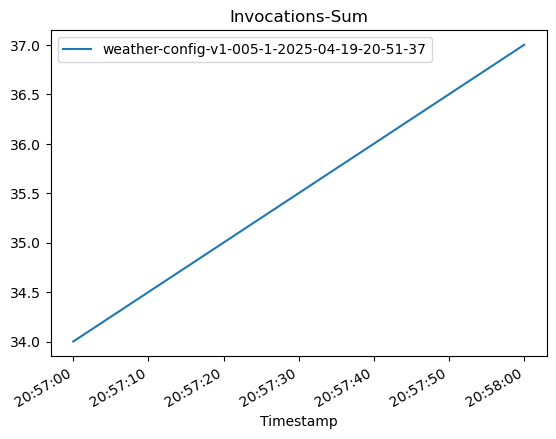

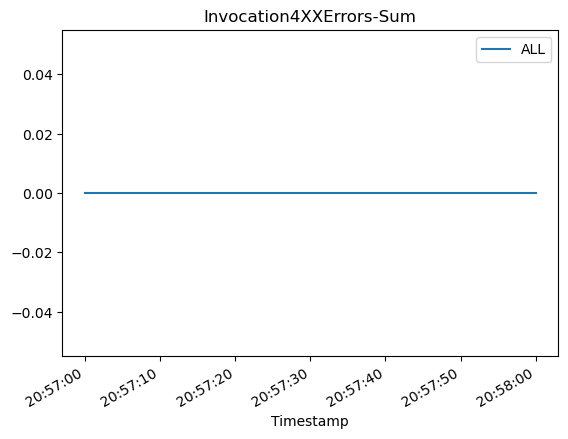

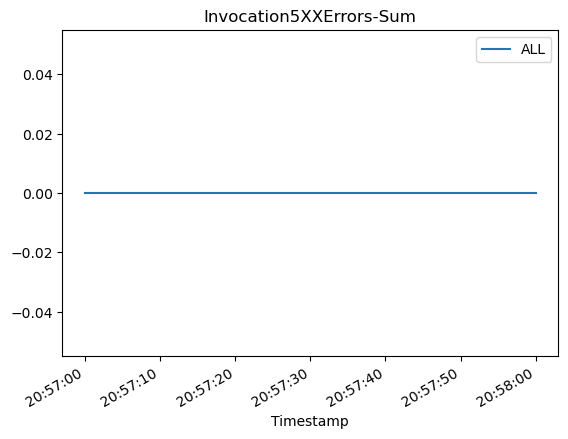

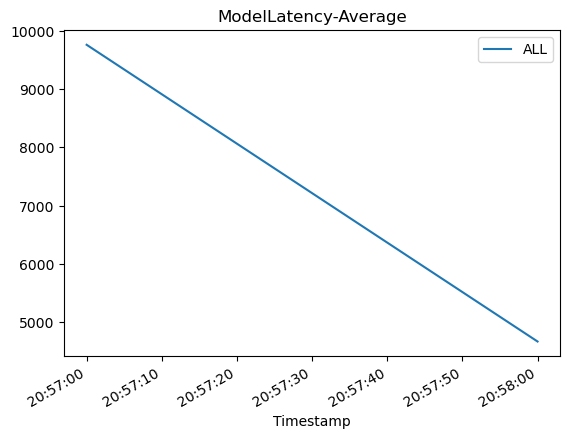

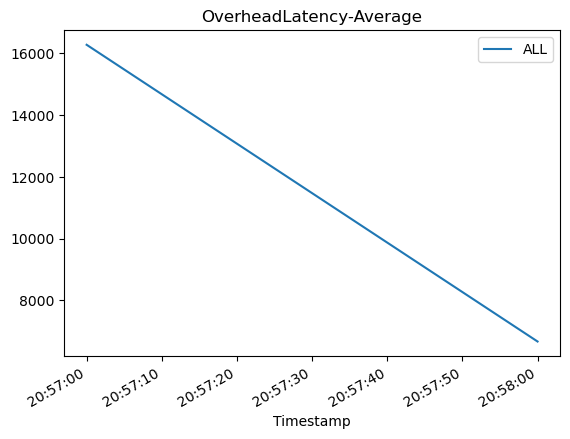

In [14]:
invocation_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name1, "AllTraffic", "Invocations", "Sum"
)
invocation_4xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation4XXErrors", "Sum"
)
invocation_5xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation5XXErrors", "Sum"
)
model_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "ModelLatency", "Average"
)
overhead_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "OverheadLatency", "Average"
)

## Create CloudWatch alarms to monitor Endpoint performance

In [15]:
def create_auto_rollback_alarm(
    alarm_name, endpoint_name, variant_name, metric_name, statistic, threshold
):
    cw.put_metric_alarm(
        AlarmName=alarm_name,
        AlarmDescription="Test SageMaker endpoint deployment auto-rollback alarm",
        ActionsEnabled=False,
        Namespace="AWS/SageMaker",
        MetricName=metric_name,
        Statistic=statistic,
        Dimensions=[
            {"Name": "EndpointName", "Value": endpoint_name},
            {"Name": "VariantName", "Value": variant_name},
        ],
        Period=60,
        EvaluationPeriods=1,
        Threshold=threshold,
        ComparisonOperator="GreaterThanOrEqualToThreshold",
        TreatMissingData="notBreaching",
    )

In [16]:
cw.delete_alarms(AlarmNames=[f"TestAlarm-5XXErrors-{endpoint_name}"])

{'ResponseMetadata': {'RequestId': 'c35c3bfd-3556-43ef-85a5-f137c22df6a4',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'c35c3bfd-3556-43ef-85a5-f137c22df6a4',
   'content-type': 'text/xml',
   'content-length': '210',
   'date': 'Sat, 19 Apr 2025 20:59:54 GMT'},
  'RetryAttempts': 0}}

In [17]:
# error rate alarm:
# Monitors 5XX errors (server-side errors)
# Named "TestAlarm-5XXErrors-[endpoint-name]"
# Triggers if average error rate hits 1 in a minute
# Watches "AllTraffic" variant (all endpoint traffic)
error_alarm1 = f"TestAlarm-5XXErrors-{endpoint_name}"
error_alarm2 = f"TestAlarm-4XXErrors-{endpoint_name}"

# latency alarm
# Monitors model inference latency
# Named "TestAlarm-ModelLatency-[endpoint-name]"
# Triggers if average latency exceeds 10,000 microseconds (10 ms)
# Also watches all traffic
latency_alarm = f"TestAlarm-ModelLatency-{endpoint_name}"

# alarm on 1 5XX error rate for 1 minute
create_auto_rollback_alarm(
    error_alarm1, endpoint_name, "AllTraffic", "Invocation5XXErrors", "Sum", 1
)

# alarm on 1 4XX error rate for 1 minute
create_auto_rollback_alarm(
    error_alarm2, endpoint_name, "AllTraffic", "Invocation4XXErrors", "Sum", 1
)

# alarm on model latency >= 10 ms for 1 minute
create_auto_rollback_alarm(
    latency_alarm, endpoint_name, "AllTraffic", "ModelLatency", "Average", 10000
)

In [19]:
# Describe the created alarms to verify their status
cw.describe_alarms(AlarmNames=[error_alarm1, error_alarm2, latency_alarm])
time.sleep(60)

## --------------------------------
## Guardrail Canary Deployments
## --------------------------------

In [20]:
from datetime import datetime

model_name_v2_1 = f"weather-model-v2-1-{datetime.now():%Y-%m-%d-%H-%M-%S}"
image_uri_ll = image_uris.retrieve("linear-learner", region)

resp_model_v2_1 = sm.create_model(
    ModelName=model_name_v2_1,
    ExecutionRoleArn=role,
    Containers=[
        {
            "Image": image_uri_ll,
            "ModelDataUrl": model_url2,  # Your 009-model.tar.gz
        }
    ]
)
print(f"✅ Created Model V2-1: {resp_model_v2_1['ModelArn']}")

[04/19/25 21:01:50] INFO     Same images used for training and inference. Defaulting to image     ]8;id=508030;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=217706;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

[04/19/25 21:01:51] INFO     Ignoring unnecessary instance type: None.                            ]8;id=879535;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=167561;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

✅ Created Model V2-1: arn:aws:sagemaker:us-east-1:796225939623:model/weather-model-v2-1-2025-04-19-21-01-50


In [21]:
ep_config_name_v2_1 = f"weather-config-v2-1-{datetime.now():%Y-%m-%d-%H-%M-%S}"

resp_ep_config_v2_1 = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name_v2_1,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name_v2_1,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 3,
        }
    ]
)
print(f"✅ Created Endpoint Config V2-1: {resp_ep_config_v2_1}")

✅ Created Endpoint Config V2-1: {'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:796225939623:endpoint-config/weather-config-v2-1-2025-04-19-21-01-56', 'ResponseMetadata': {'RequestId': '1035465c-d5e1-4a0d-92c3-9d1399bf5401', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '1035465c-d5e1-4a0d-92c3-9d1399bf5401', 'content-type': 'application/x-amz-json-1.1', 'content-length': '120', 'date': 'Sat, 19 Apr 2025 21:01:56 GMT'}, 'RetryAttempts': 0}}


In [24]:
canary_deployment_config = {
    "BlueGreenUpdatePolicy": {
        "TrafficRoutingConfiguration": {
            "Type": "CANARY",
            "CanarySize": {
                "Type": "INSTANCE_COUNT",
                "Value": 1,
            },
            "WaitIntervalInSeconds": 300,
        },
        "TerminationWaitInSeconds": 120,
        "MaximumExecutionTimeoutInSeconds": 1800,
    },
    "AutoRollbackConfiguration": {
        "Alarms": [{"AlarmName": error_alarm1}, {"AlarmName": error_alarm2}, {"AlarmName": latency_alarm}],
    },
}

In [25]:
sm.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=ep_config_name_v2_1,
    DeploymentConfig=canary_deployment_config,
)
print("✅ Canary deployment started with config V2-1 (Linear Learner)")

✅ Canary deployment started with config V2-1 (Linear Learner)


In [26]:
status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
print(f"🔁 Current Endpoint Status: {status}")

🔁 Current Endpoint Status: Updating


In [30]:
def invoke_endpoint(
    endpoint_name, max_invocations=600, wait_interval_sec=1, should_raise_exp=False
):
    print(f"Sending test traffic to the endpoint {endpoint_name}. \nPlease wait...")

    count = 0
    with open("test_data/test_linear_input_cols.csv", "r") as f:
        for row in f:
            payload = row.rstrip("\n")
            try:
                response = sm_runtime.invoke_endpoint(
                    EndpointName=endpoint_name,
                    ContentType="text/csv",
                    Body=payload
                )
                response["Body"].read()
                print(".", end="", flush=True)
            except Exception as e:
                print("E", end="", flush=True)
                if should_raise_exp:
                    raise e

            count += 1
            if count > max_invocations:
                break

            time.sleep(wait_interval_sec)

    print("\nDone!")

# Trigger with 100 requests
invoke_endpoint(endpoint_name, max_invocations=100)

Sending test traffic to the endpoint weather-prediction-endpoint-2025-04-19-20-51-56. 
Please wait...
.....................................................................................................
Done!


In [31]:
status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
print(f"🔁 Current Endpoint Status: {status}")

🔁 Current Endpoint Status: InService


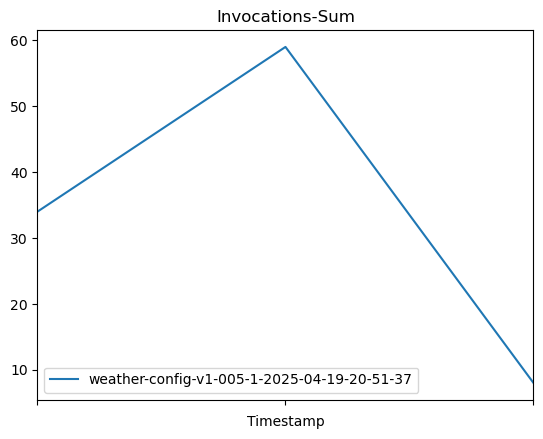

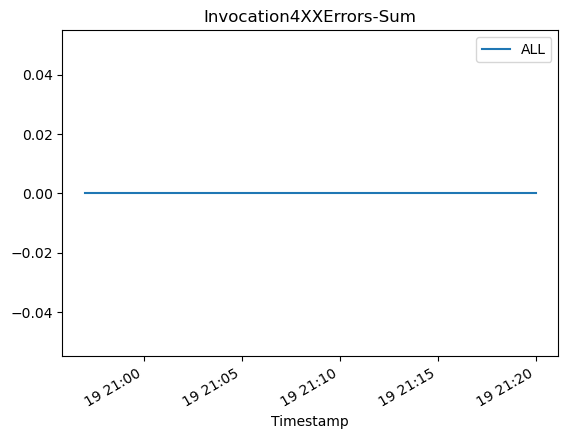

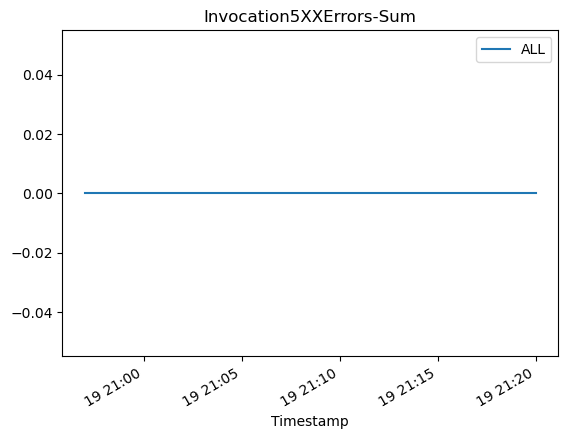

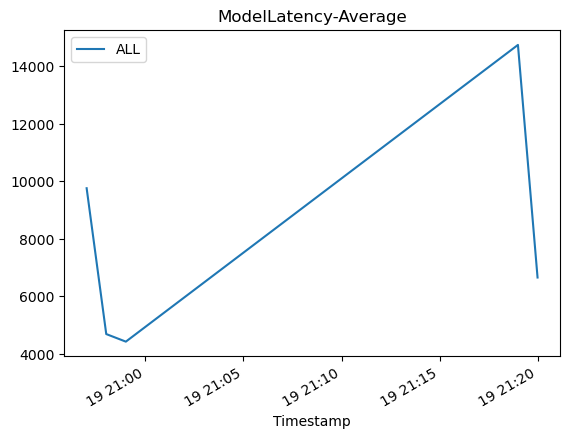

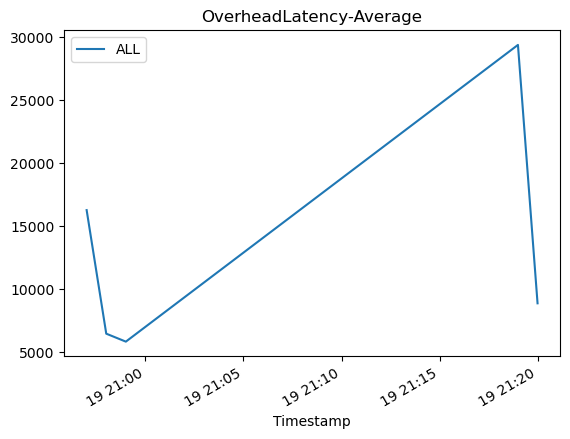

In [32]:
invocation_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name1, "AllTraffic", "Invocations", "Sum"
)
invocation_4xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation4XXErrors", "Sum"
)
invocation_5xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation5XXErrors", "Sum"
)
model_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "ModelLatency", "Average"
)
overhead_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "OverheadLatency", "Average"
)

### Creation of Incompatible Image URI (XGBoost) to Simulate Failure

In [33]:
# Incompatible model image (XGBoost instead of Linear Learner)
bad_image_uri = image_uris.retrieve("xgboost", region, version="1.2-1")
print(f"Bad (Incompatible) Model Image URI: {bad_image_uri}")

[04/19/25 21:23:13] INFO     Ignoring unnecessary instance type: None.                            ]8;id=263446;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=895019;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

Bad (Incompatible) Model Image URI: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-xgboost:1.2-1


###  Creation of Model Using This Incompatible Algorithm (Image Uri)

In [34]:
bad_model_name = f"weather-model-v2-bad-{datetime.now():%Y-%m-%d-%H-%M-%S}"
print(f"Incompatible Model Name: {bad_model_name}")

# Create model with XGBoost (wrong algorithm)
resp_bad_model = sm.create_model(
    ModelName=bad_model_name,
    ExecutionRoleArn=role,
    Containers=[
        {
            "Image": bad_image_uri,
            "ModelDataUrl": model_url2,  # 009-model.tar.gz (used in V2)
        }
    ]
)
print(f"✅ Created Incompatible Model: {resp_bad_model['ModelArn']}")

Incompatible Model Name: weather-model-v2-bad-2025-04-19-21-23-24
✅ Created Incompatible Model: arn:aws:sagemaker:us-east-1:796225939623:model/weather-model-v2-bad-2025-04-19-21-23-24


### Creation of Endpoint Config for the Bad Model

In [35]:
bad_ep_config_name = f"weather-config-v2-bad-{datetime.now():%Y-%m-%d-%H-%M-%S}"
print(f"Incompatible Endpoint Config: {bad_ep_config_name}")

resp_bad_config = sm.create_endpoint_config(
    EndpointConfigName=bad_ep_config_name,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": bad_model_name,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 3,
        }
    ]
)
print(f"✅ Created Bad Endpoint Config: {resp_bad_config}")

Incompatible Endpoint Config: weather-config-v2-bad-2025-04-19-21-23-29
✅ Created Bad Endpoint Config: {'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:796225939623:endpoint-config/weather-config-v2-bad-2025-04-19-21-23-29', 'ResponseMetadata': {'RequestId': '062300ee-3d4b-4e8c-9ff3-9a6dd476c0f9', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': '062300ee-3d4b-4e8c-9ff3-9a6dd476c0f9', 'content-type': 'application/x-amz-json-1.1', 'content-length': '122', 'date': 'Sat, 19 Apr 2025 21:23:29 GMT'}, 'RetryAttempts': 0}}


### Define & Trigger the Canary Deployment (to simulate failure & rollback)

In [36]:
canary_deployment_config = {
    "BlueGreenUpdatePolicy": {
        "TrafficRoutingConfiguration": {
            "Type": "CANARY",
            "CanarySize": {
                "Type": "INSTANCE_COUNT",
                "Value": 1,
            },
            "WaitIntervalInSeconds": 300,
        },
        "TerminationWaitInSeconds": 120,
        "MaximumExecutionTimeoutInSeconds": 1800,
    },
    "AutoRollbackConfiguration": {
        "Alarms": [{"AlarmName": error_alarm1}, {"AlarmName": error_alarm2}, {"AlarmName": latency_alarm}],
    },
}

# Attach incompatible config to endpoint with rollback strategy
sm.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=bad_ep_config_name,
    DeploymentConfig=canary_deployment_config,
)
print("🚨 Canary deployment triggered with incompatible model.")


🚨 Canary deployment triggered with incompatible model.


In [37]:
status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
print(f"🔁 Current Endpoint Status: {status}")

🔁 Current Endpoint Status: Updating


In [38]:
# Trigger with 100 requests
invoke_endpoint(endpoint_name, max_invocations=100)

Sending test traffic to the endpoint weather-prediction-endpoint-2025-04-19-20-51-56. 
Please wait...
.....................................................................................................
Done!


In [39]:
invoke_endpoint(endpoint_name)

Sending test traffic to the endpoint weather-prediction-endpoint-2025-04-19-20-51-56. 
Please wait...
.................................................................................................................................E..EE..E..EE..E.EE..EE......E..E...E.............E....E...E.....EE...EE..E..EE...EEEEEEEE.E.EE.........EE...E...E..EEE...E.EE..E....EEE..E........E.E.E.E...EE...EE.....E..E............................................................................................................................................................................................................................................................................................................
Done!


In [43]:
status = desc["EndpointStatus"]
print(f"🔄 Current Endpoint Status: {status}")

🔄 Current Endpoint Status: InService


In [44]:
sm.describe_endpoint(EndpointName=endpoint_name)

{'EndpointName': 'weather-prediction-endpoint-2025-04-19-20-51-56',
 'EndpointArn': 'arn:aws:sagemaker:us-east-1:796225939623:endpoint/weather-prediction-endpoint-2025-04-19-20-51-56',
 'EndpointConfigName': 'weather-config-v2-1-2025-04-19-21-01-56',
 'ProductionVariants': [{'VariantName': 'AllTraffic',
   'DeployedImages': [{'SpecifiedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner:1',
     'ResolvedImage': '382416733822.dkr.ecr.us-east-1.amazonaws.com/linear-learner@sha256:2e3a9eeeb8246b7f2a0438e39457ffce204e200676693566b021e31c9291cb68',
     'ResolutionTime': datetime.datetime(2025, 4, 19, 21, 7, 48, 487000, tzinfo=tzlocal())}],
   'CurrentWeight': 1.0,
   'DesiredWeight': 1.0,
   'CurrentInstanceCount': 3,
   'DesiredInstanceCount': 3}],
 'EndpointStatus': 'InService',
 'FailureReason': 'One or more configured alarm for automatic rollback deployment is in ALARM state: [TestAlarm-5XXErrors-weather-prediction-endpoint-2025-04-19-20-51-56].',
 'CreationTime': dat

In [45]:
desc = sm.describe_endpoint(EndpointName=endpoint_name)
current_config = desc["EndpointConfigName"]
print(f"🧾 Currently attached endpoint config: {current_config}")

🧾 Currently attached endpoint config: weather-config-v2-1-2025-04-19-21-01-56


In [46]:
status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
print(f"🔁 Current Endpoint Status: {status}")

🔁 Current Endpoint Status: InService


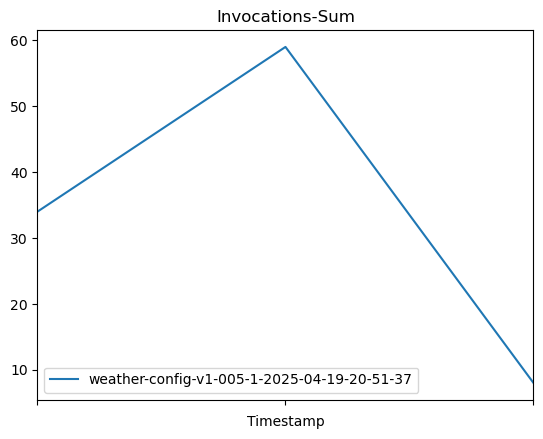

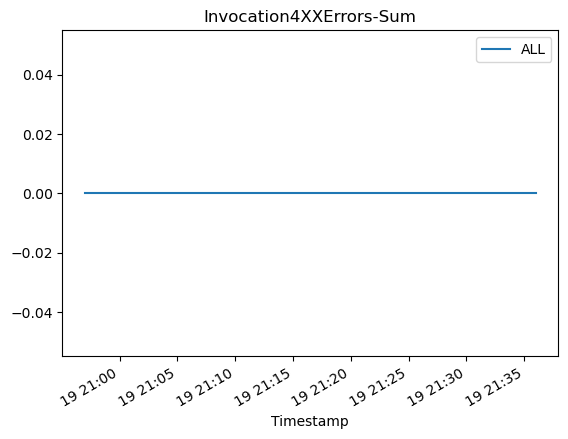

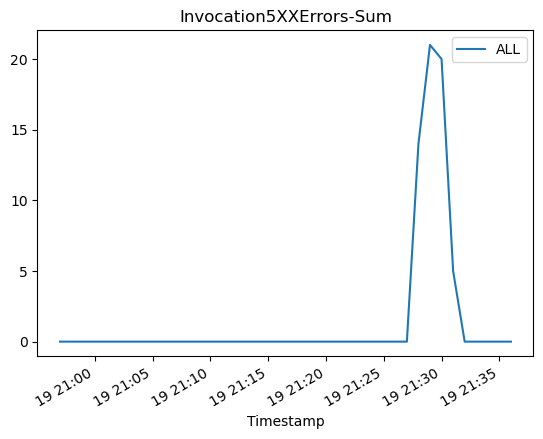

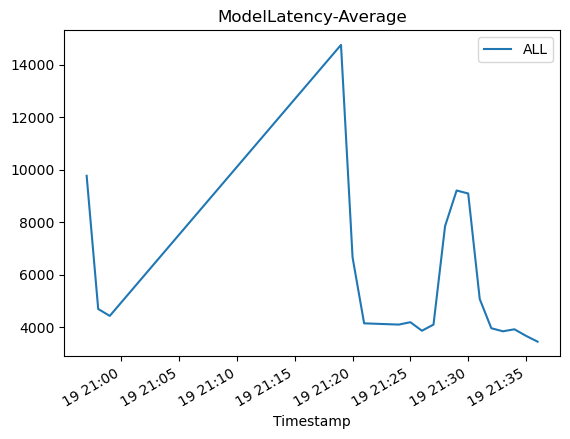

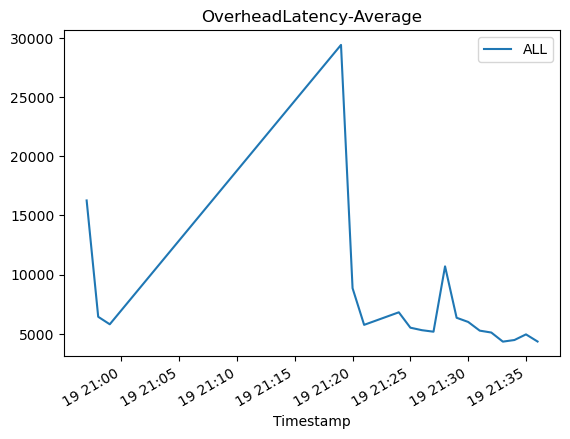

In [47]:
invocation_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name1, "AllTraffic", "Invocations", "Sum"
)
invocation_4xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation4XXErrors", "Sum"
)
invocation_5xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation5XXErrors", "Sum"
)
model_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "ModelLatency", "Average"
)
overhead_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "OverheadLatency", "Average"
)

## Cloudwatch Log Screenshots

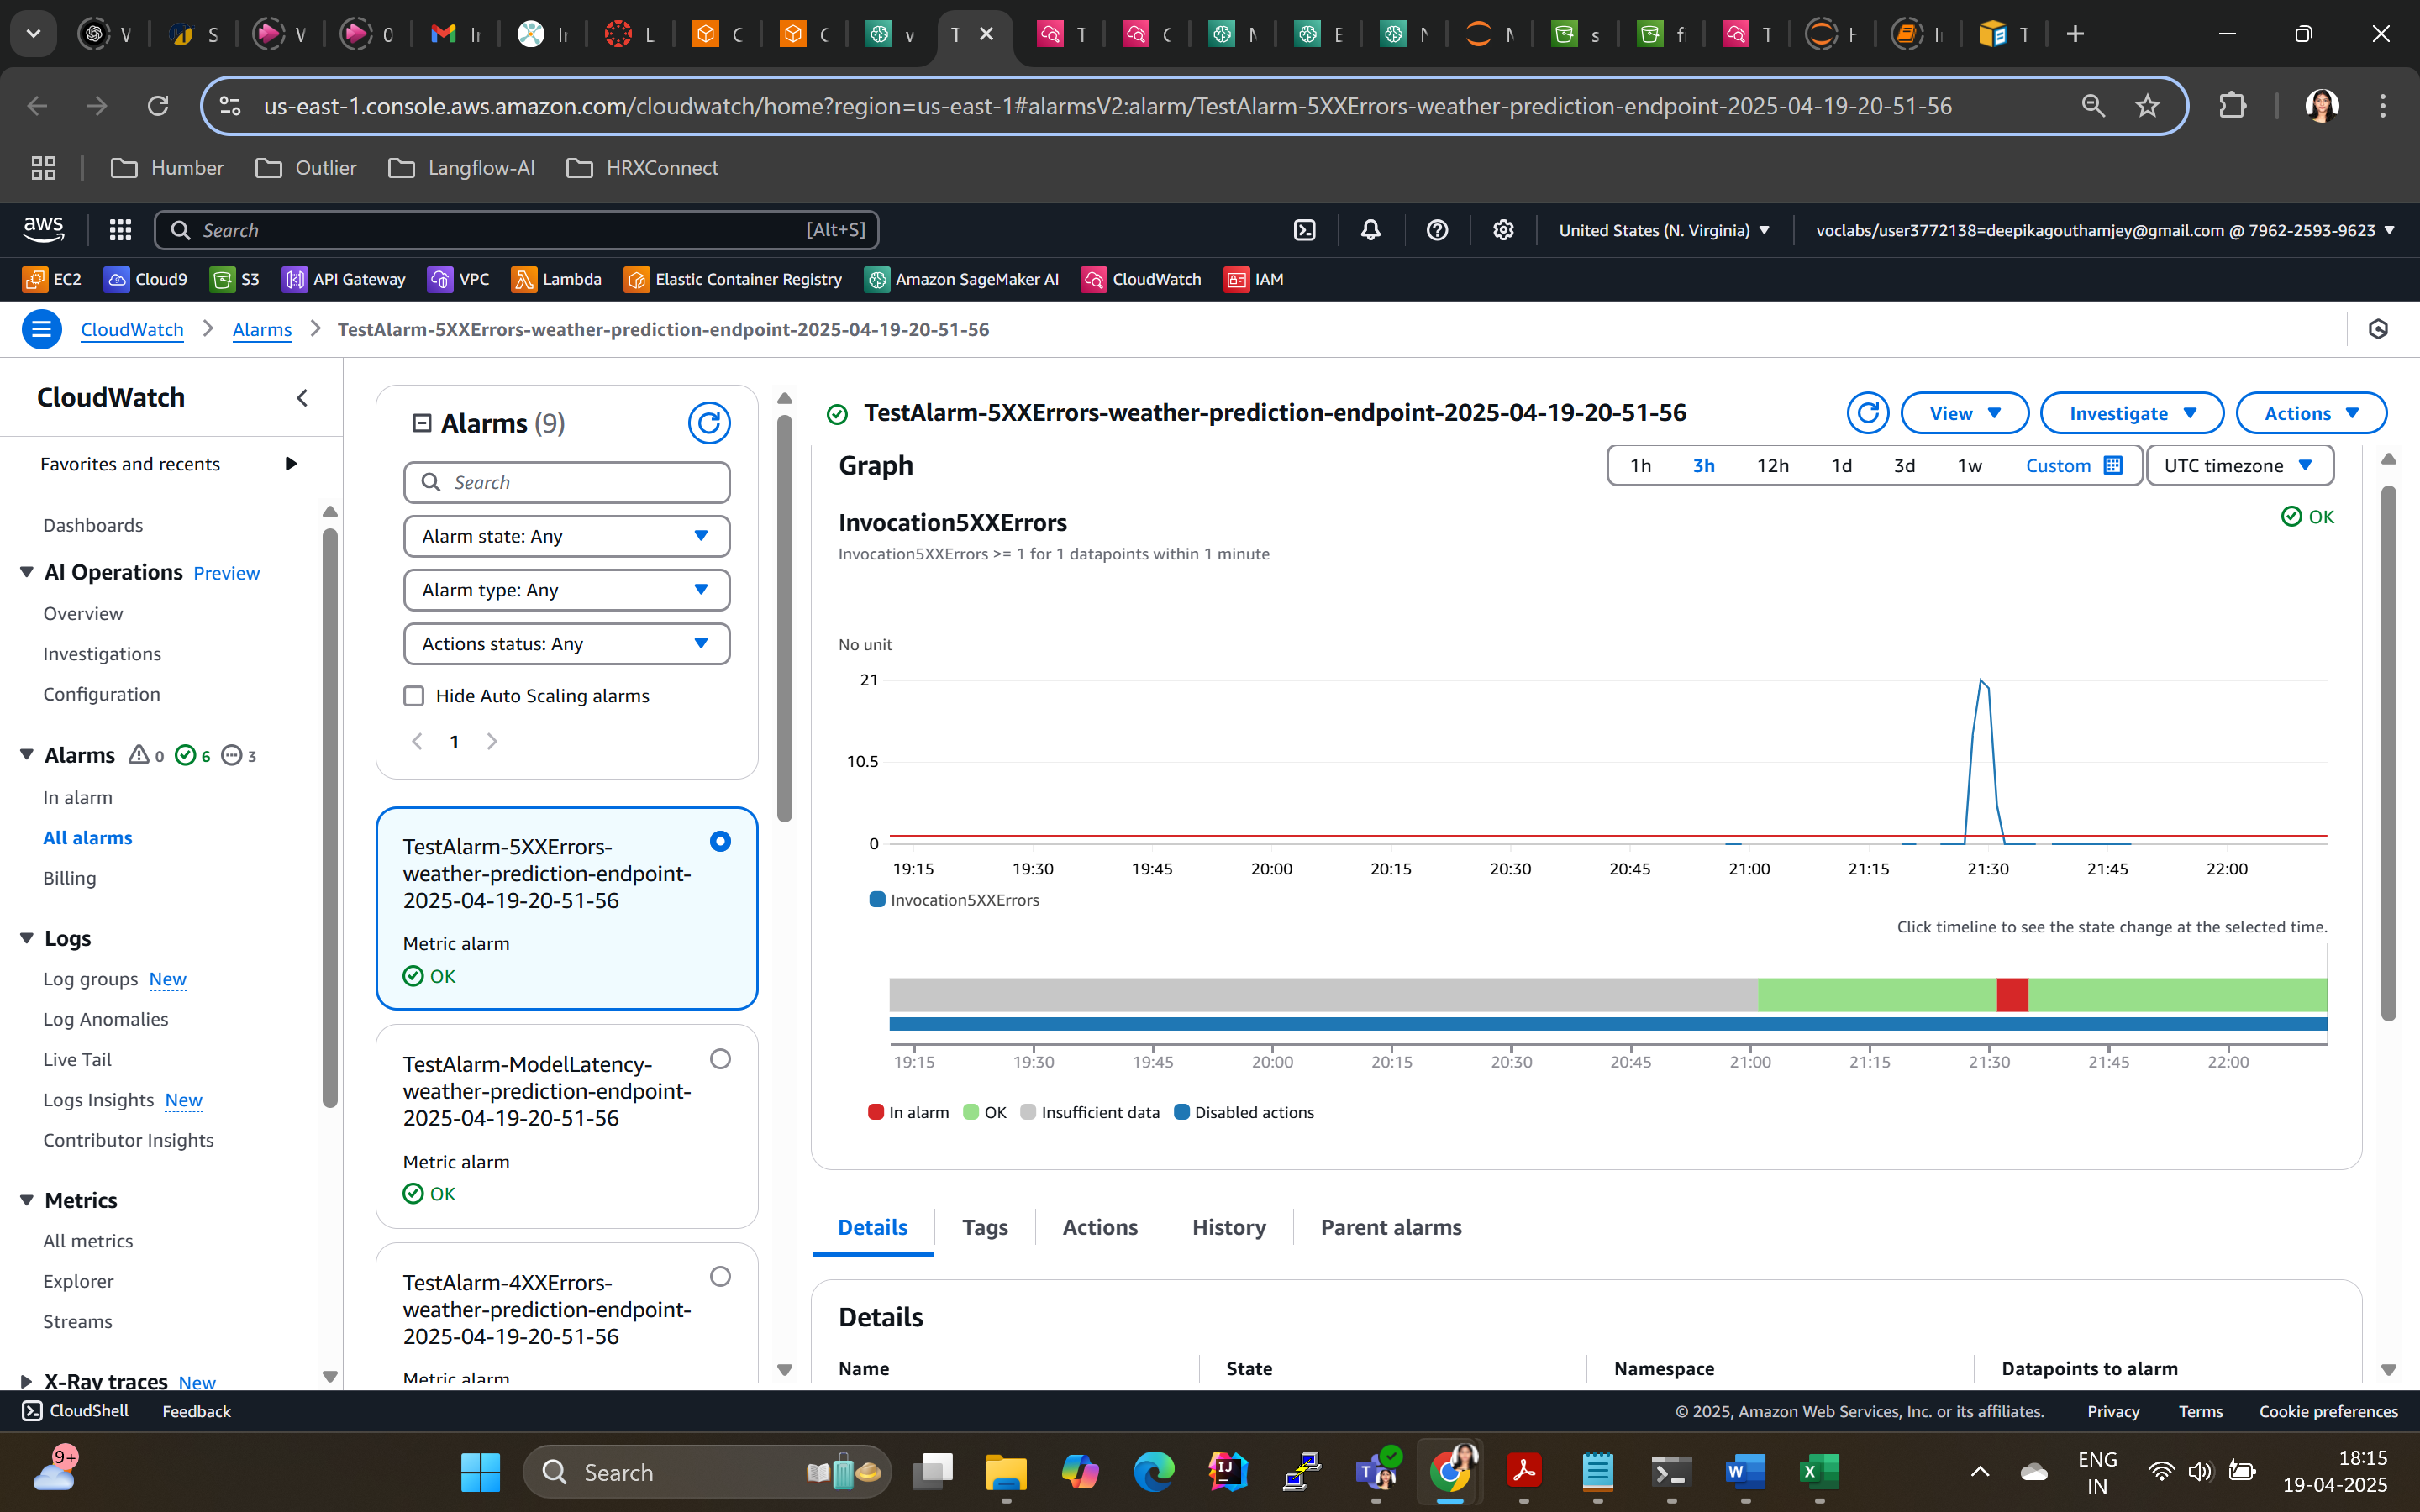

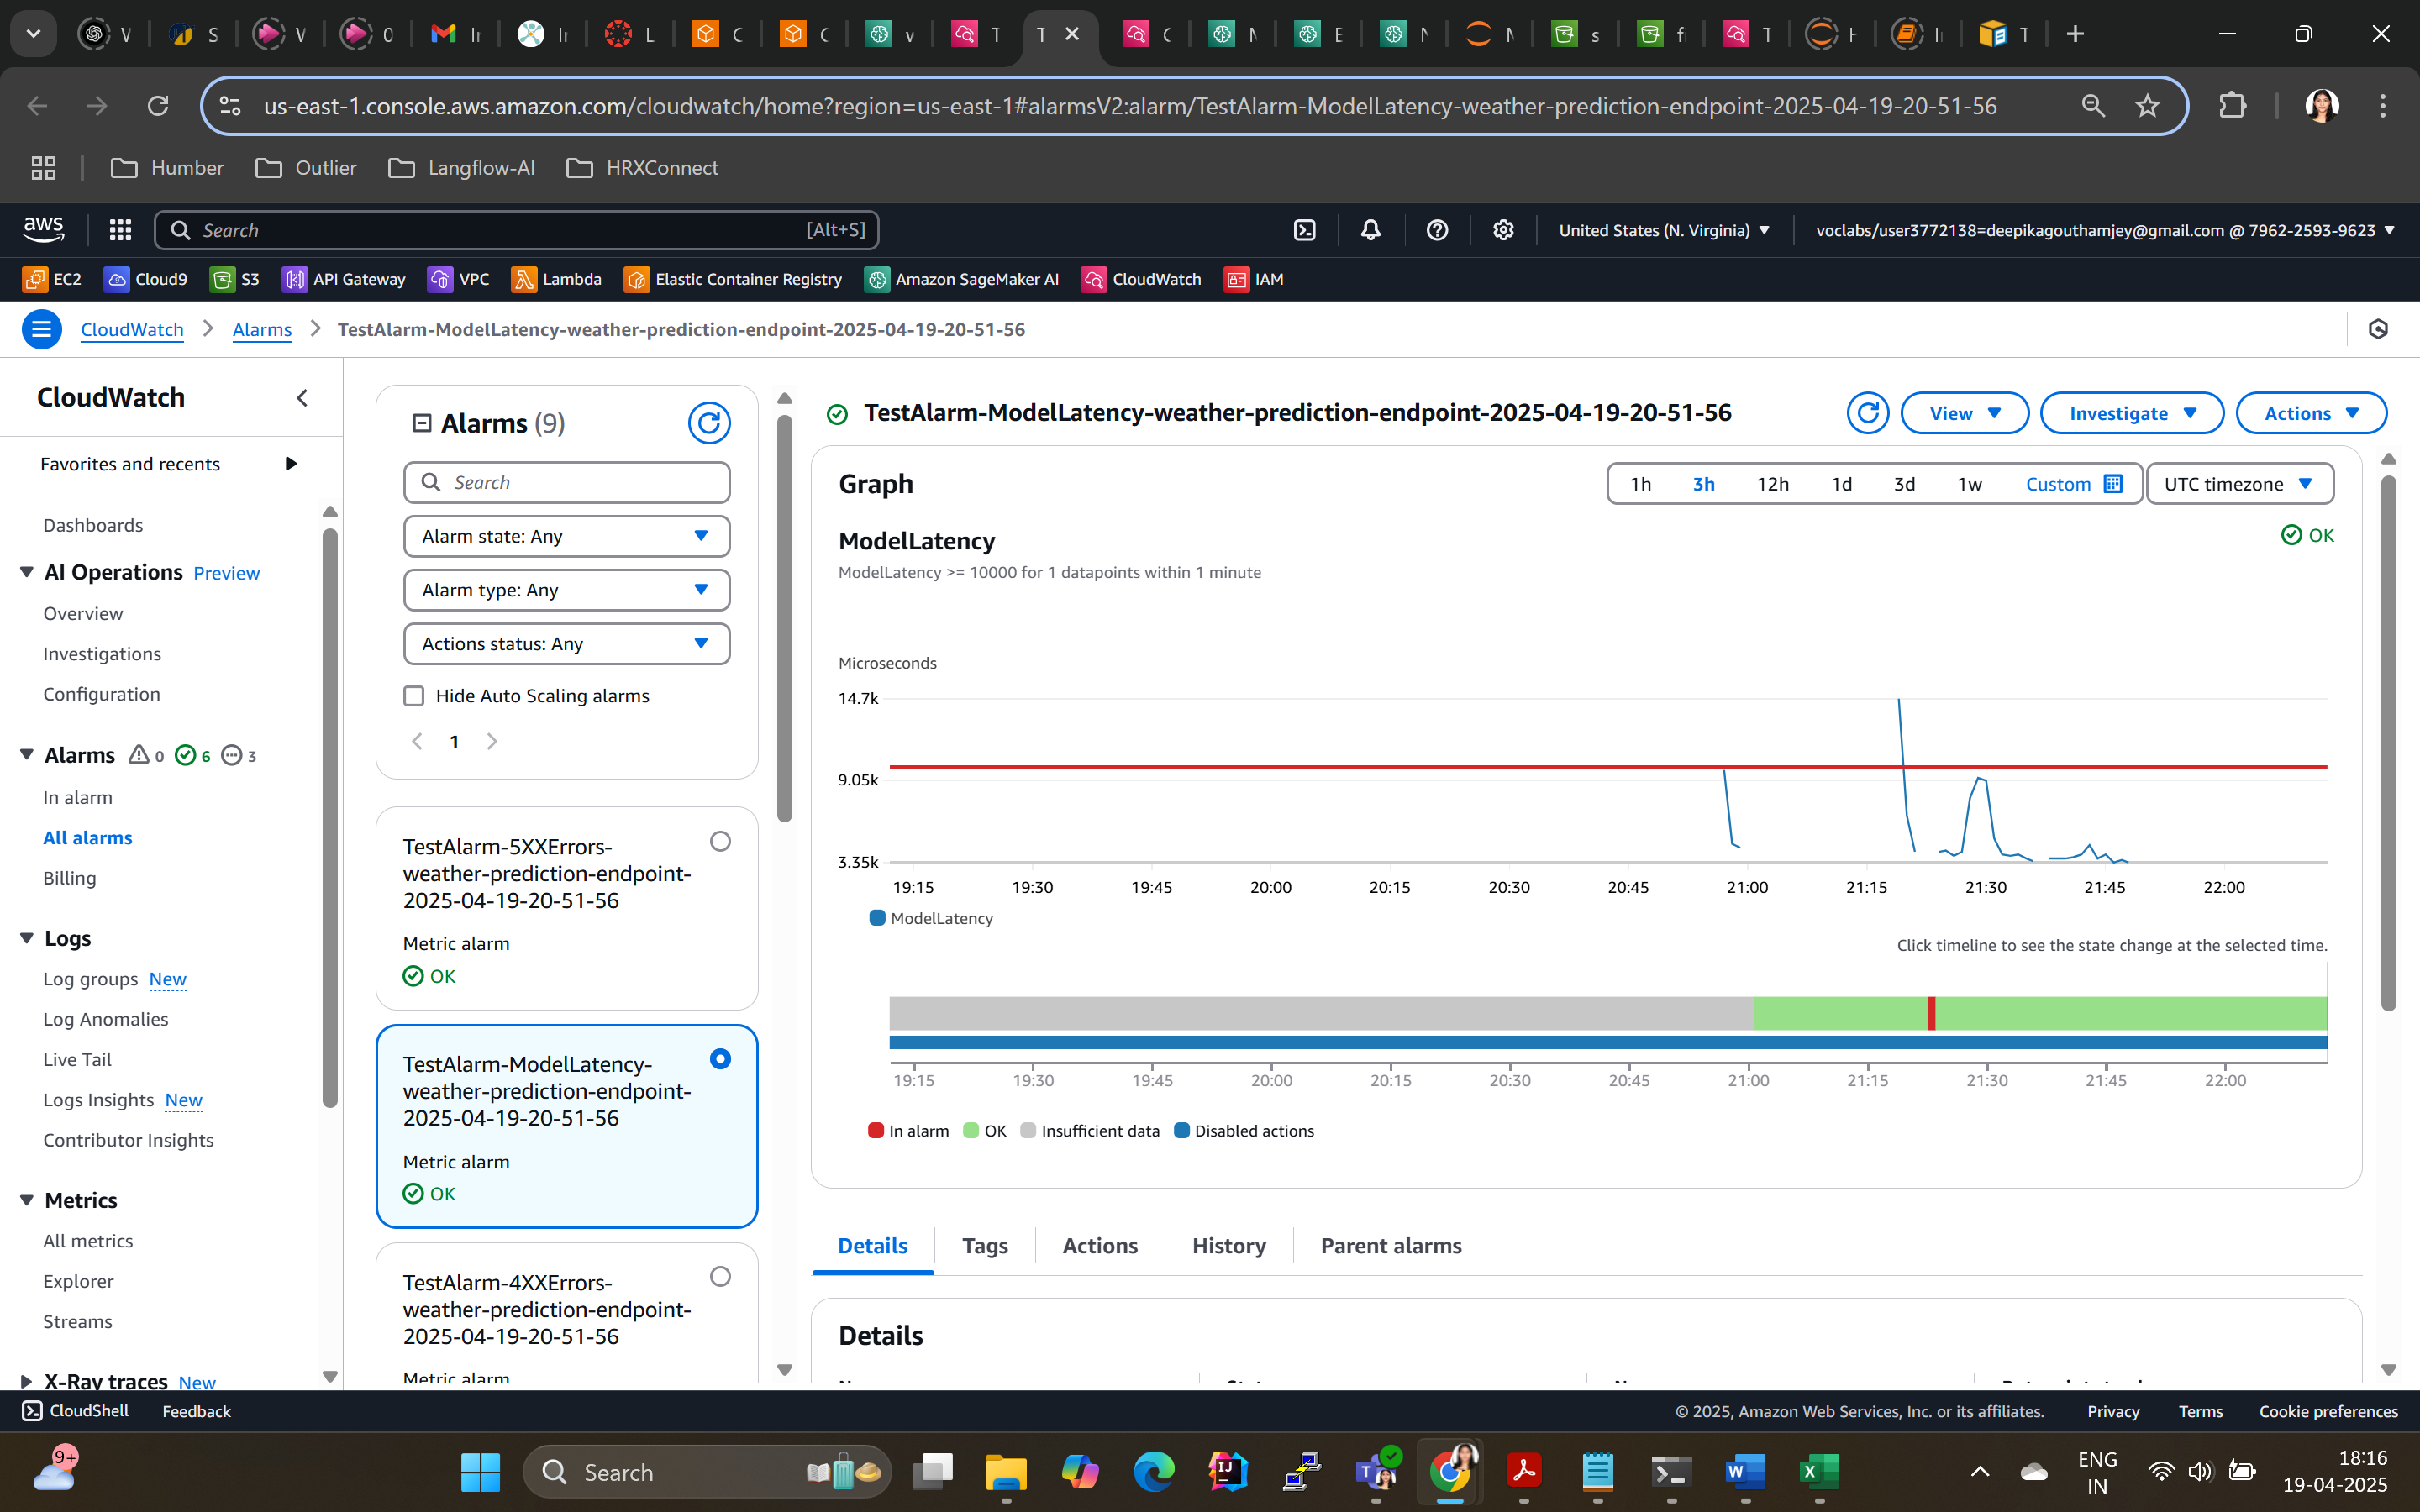

## Success Canary Deployment

In [48]:
from sagemaker import image_uris
from datetime import datetime

# 🔹 Step 1: Create model V2-3 (Linear Learner)
model_name_v2_3 = f"weather-model-v2-3-{datetime.now():%Y-%m-%d-%H-%M-%S}"
image_uri_ll = image_uris.retrieve("linear-learner", region)

resp_model_v2_3 = sm.create_model(
    ModelName=model_name_v2_3,
    ExecutionRoleArn=role,
    Containers=[
        {
            "Image": image_uri_ll,
            "ModelDataUrl": model_url2,  # 009-model.tar.gz (high-performing)
        }
    ]
)
print(f"✅ Created Model V2-3: {resp_model_v2_3['ModelArn']}")

[04/19/25 21:37:37] INFO     Same images used for training and inference. Defaulting to image     ]8;id=449210;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=675330;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=683785;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=175860;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

✅ Created Model V2-3: arn:aws:sagemaker:us-east-1:796225939623:model/weather-model-v2-3-2025-04-19-21-37-37


In [49]:
# 🔹 Step 2: Create endpoint config V2-3
ep_config_name_v2_3 = f"weather-config-v2-3-{datetime.now():%Y-%m-%d-%H-%M-%S}"

resp_ep_config_v2_3 = sm.create_endpoint_config(
    EndpointConfigName=ep_config_name_v2_3,
    ProductionVariants=[
        {
            "VariantName": "AllTraffic",
            "ModelName": model_name_v2_3,
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 3,
        }
    ]
)
print(f"✅ Created Endpoint Config V2-3: {resp_ep_config_v2_3}")

✅ Created Endpoint Config V2-3: {'EndpointConfigArn': 'arn:aws:sagemaker:us-east-1:796225939623:endpoint-config/weather-config-v2-3-2025-04-19-21-37-44', 'ResponseMetadata': {'RequestId': 'e237f2dd-3fbe-4f42-84a2-fa26dfe7330c', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amzn-requestid': 'e237f2dd-3fbe-4f42-84a2-fa26dfe7330c', 'content-type': 'application/x-amz-json-1.1', 'content-length': '120', 'date': 'Sat, 19 Apr 2025 21:37:44 GMT'}, 'RetryAttempts': 0}}


In [50]:
# 🔹 Step 3: Update endpoint with V2-3 config using canary strategy
sm.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=ep_config_name_v2_3,
    DeploymentConfig=canary_deployment_config,
)
print("✅ Canary deployment started with config V2-3 (Linear Learner — success after rollback)")

✅ Canary deployment started with config V2-3 (Linear Learner — success after rollback)


In [51]:
invoke_endpoint(endpoint_name)

Sending test traffic to the endpoint weather-prediction-endpoint-2025-04-19-20-51-56. 
Please wait...
.........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................
Done!


In [52]:
def wait_for_endpoint_in_service(endpoint_name):
    print("Waiting for endpoint in service")
    while True:
        details = sm.describe_endpoint(EndpointName=endpoint_name)
        status = details["EndpointStatus"]
        if status in ["InService", "Failed"]:
            print("\nDone!")
            break
        print(".", end="", flush=True)
        time.sleep(30)


wait_for_endpoint_in_service(endpoint_name)

Waiting for endpoint in service
....
Done!


In [53]:
status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
print(f"🔁 Current Endpoint Status: {status}")

🔁 Current Endpoint Status: InService


In [54]:
desc = sm.describe_endpoint(EndpointName=endpoint_name)
current_config = desc["EndpointConfigName"]
print(f"🧾 Currently attached endpoint config: {current_config}")

🧾 Currently attached endpoint config: weather-config-v2-3-2025-04-19-21-37-44


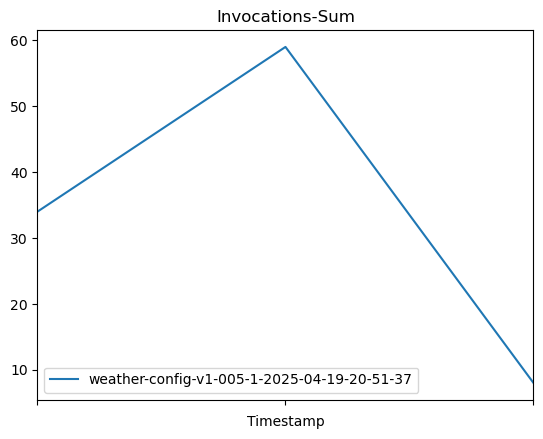

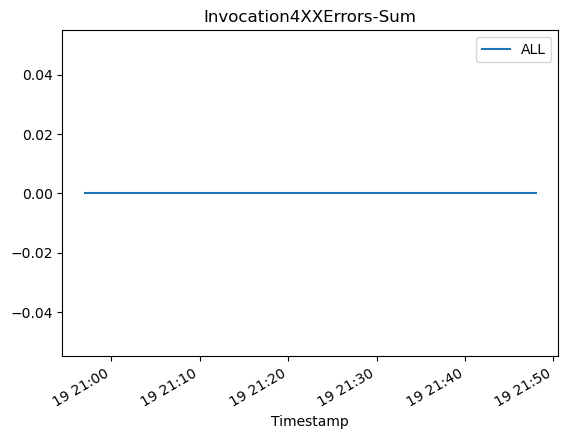

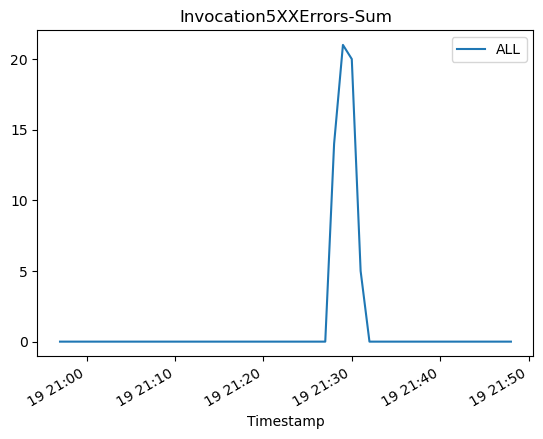

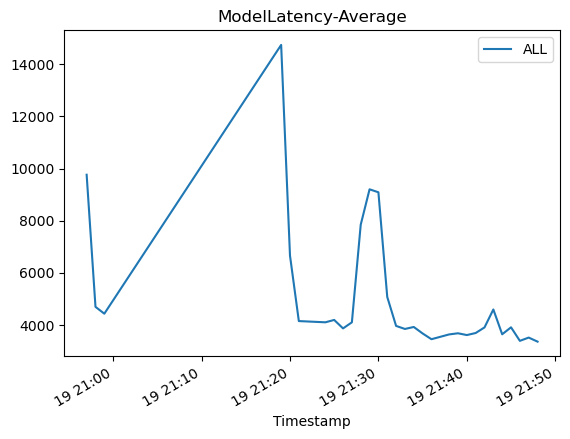

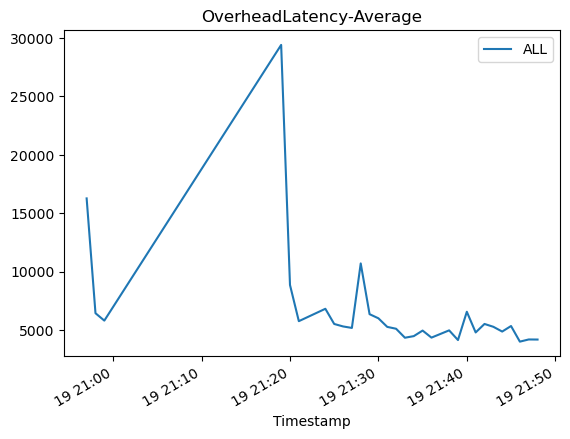

In [55]:
invocation_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, ep_config_name1, "AllTraffic", "Invocations", "Sum"
)
invocation_4xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation4XXErrors", "Sum"
)
invocation_5xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "Invocation5XXErrors", "Sum"
)
model_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "ModelLatency", "Average"
)
overhead_latency_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "AllTraffic", "OverheadLatency", "Average"
)

## ----------------------
## Shadow Testing
## ----------------------

In [56]:
import boto3
from sagemaker import get_execution_role, Session, image_uris
from datetime import datetime

# AWS region and session setup
aws_region = "us-east-1"
boto_session = boto3.Session(region_name=aws_region)
sagemaker_client = boto_session.client("sagemaker")
role = get_execution_role()

# Your fixed S3 bucket and model paths
bucket = "final-project-drk"
prefix = "sagemaker/RealTime-Weather-Deployment-Guardrails-Canary"
model_url_v1 = f"s3://{bucket}/{prefix}/005-model.tar.gz"
model_url_v2 = f"s3://{bucket}/{prefix}/009-model.tar.gz"

# Retrieve Linear Learner image URI
image_uri = image_uris.retrieve("linear-learner", region=aws_region)

# Timestamped model names for shadow testing
model_name_prod = f"weather-model-shadow-prod-{datetime.now():%Y-%m-%d-%H-%M-%S}"
model_name_shadow = f"weather-model-shadow-alt-{datetime.now():%Y-%m-%d-%H-%M-%S}"

# Create production model (005)
sagemaker_client.create_model(
    ModelName=model_name_prod,
    ExecutionRoleArn=role,
    Containers=[
        {
            "Image": image_uri,
            "ModelDataUrl": model_url_v1
        }
    ]
)

# Create shadow model (009)
sagemaker_client.create_model(
    ModelName=model_name_shadow,
    ExecutionRoleArn=role,
    Containers=[
        {
            "Image": image_uri,
            "ModelDataUrl": model_url_v2
        }
    ]
)

print(f"✅ Created models for shadow testing:\n- Production: {model_name_prod}\n- Shadow: {model_name_shadow}")

[04/19/25 21:57:19] INFO     Found credentials from IAM Role:                                   ]8;id=539277;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=704968;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Found credentials from IAM Role:                                   ]8;id=789928;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py\credentials.py]8;;\:]8;id=618243;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/botocore/credentials.py#1132\1132]8;;\
                             BaseNotebookInstanceEc2InstanceRole                                                   

                    INFO     Same images used for training and inference. Defaulting to image     ]8;id=772849;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=95448;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#393\393]8;;\
                             scope: inference.                                                                     

                    INFO     Ignoring unnecessary instance type: None.                            ]8;id=737257;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py\image_uris.py]8;;\:]8;id=958444;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/sagemaker/image_uris.py#530\530]8;;\

✅ Created models for shadow testing:
- Production: weather-model-shadow-prod-2025-04-19-21-57-19
- Shadow: weather-model-shadow-alt-2025-04-19-21-57-19


In [57]:
from datetime import datetime

# Name your shadow testing endpoint config
endpoint_config_name_shadow = f"weather-config-shadow-{datetime.now():%Y-%m-%d-%H-%M-%S}"

create_endpoint_config_response = sagemaker_client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name_shadow,
    ProductionVariants=[
        {
            "VariantName": "ProdVariant",
            "ModelName": model_name_prod,          # 005-model.tar.gz
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 1,
        }
    ],
    ShadowProductionVariants=[
        {
            "VariantName": "ShadowVariant",
            "ModelName": model_name_shadow,        # 009-model.tar.gz
            "InstanceType": "ml.m5.xlarge",
            "InitialInstanceCount": 1,
            "InitialVariantWeight": 1,
        }
    ]
)

print(f"✅ Created endpoint config with shadow testing: {endpoint_config_name_shadow}")

✅ Created endpoint config with shadow testing: weather-config-shadow-2025-04-19-21-58-18


In [58]:
# Attach shadow testing config to your existing endpoint
create_endpoint_response = sm.update_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name_shadow,
)

print(f"✅ Shadow Testing Deployment Started for Endpoint: {endpoint_name}")

✅ Shadow Testing Deployment Started for Endpoint: weather-prediction-endpoint-2025-04-19-20-51-56


In [59]:
status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
print(f"🔁 Current Endpoint Status: {status}")

def wait_for_endpoint_in_service(endpoint_name):
    print("Waiting for endpoint in service")
    while True:
        details = sm.describe_endpoint(EndpointName=endpoint_name)
        status = details["EndpointStatus"]
        if status in ["InService", "Failed"]:
            print("\nDone!")
            break
        print(".", end="", flush=True)
        time.sleep(30)


wait_for_endpoint_in_service(endpoint_name)

🔁 Current Endpoint Status: Updating
Waiting for endpoint in service
.....
Done!


In [62]:
desc = sm.describe_endpoint(EndpointName=endpoint_name)
current_config = desc["EndpointConfigName"]
print(f"🧾 Currently attached endpoint config: {current_config}")

🧾 Currently attached endpoint config: weather-config-shadow-2025-04-19-21-58-18


In [76]:
def invoke_endpoint(endpoint_name, should_raise_exp=False):
    with open("test_data/test_linear_input_cols.csv", "r") as f:
        for row_index, row in enumerate(f):
            if row_index == 0:
                continue  # ✅ Skip header
            if row_index > 10:
                break  # ✅ Limit to 10 rows (not endless)
            payload = row.rstrip("\n")
            try:
                for i in range(10):  # send the same payload 10 times
                    response = sm_runtime.invoke_endpoint(
                        EndpointName=endpoint_name,
                        ContentType="text/csv",
                        Body=payload
                    )
                    print(".", end="", flush=True)
            except Exception as e:
                print("E", end="", flush=True)
                if should_raise_exp:
                    raise e

In [77]:
invoke_endpoint(endpoint_name)

....................................................................................................

In [78]:
status = sm.describe_endpoint(EndpointName=endpoint_name)["EndpointStatus"]
print(f"🔁 Current Endpoint Status: {status}")

desc = sm.describe_endpoint(EndpointName=endpoint_name)
current_config = desc["EndpointConfigName"]
print(f"🧾 Currently attached endpoint config: {current_config}")

🔁 Current Endpoint Status: InService
🧾 Currently attached endpoint config: weather-config-shadow-2025-04-19-21-58-18


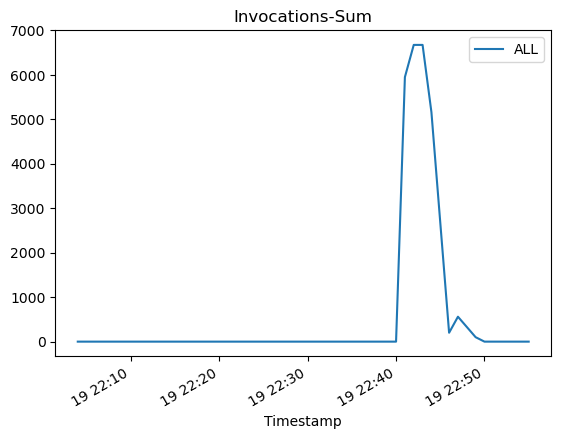

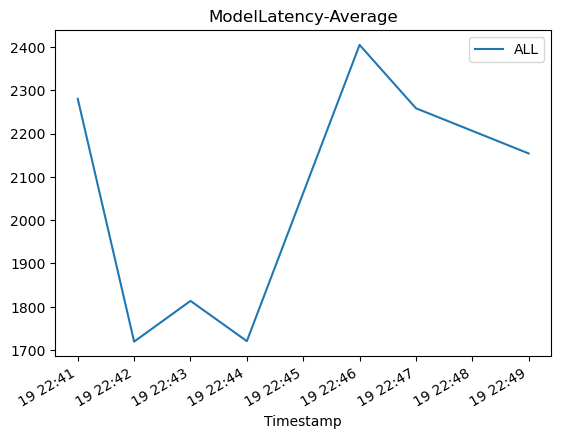

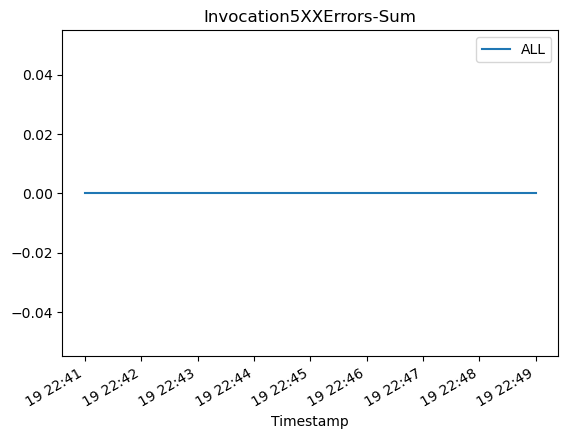

In [88]:
prod_invocation = plot_endpoint_invocation_metrics(
    endpoint_name, None, "ProdVariant", "Invocations", "Sum"
)
prod_latency = plot_endpoint_invocation_metrics(
    endpoint_name, None, "ProdVariant", "ModelLatency", "Average"
)
prod_invocation_5xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "ProdVariant", "Invocation5XXErrors", "Sum"
)

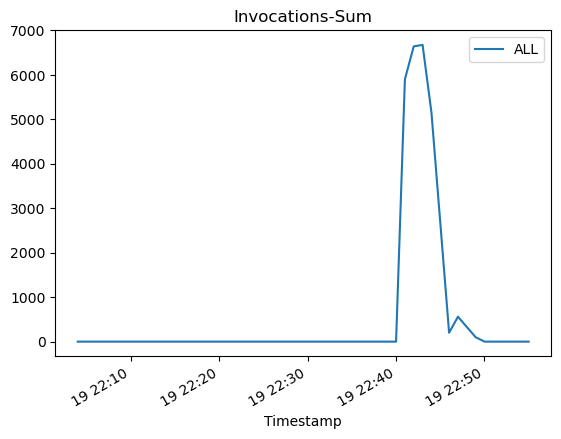

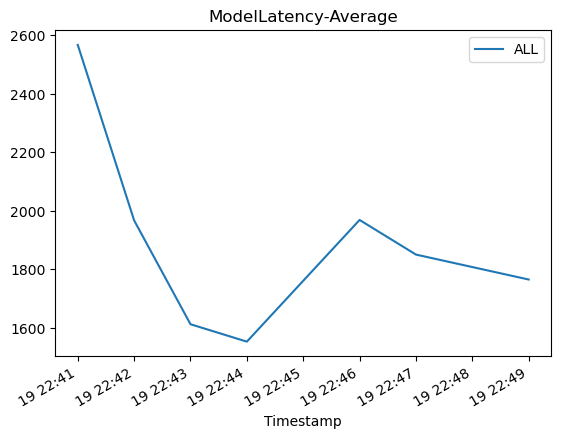

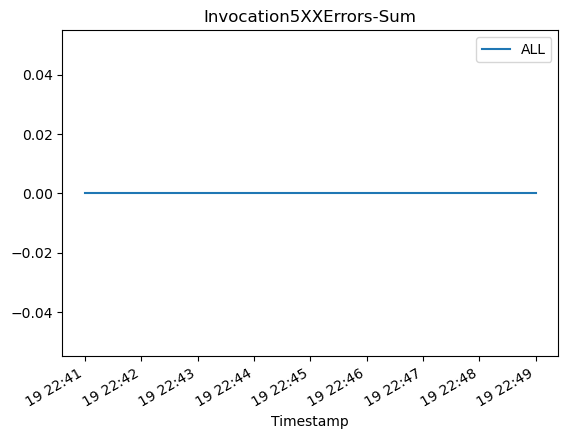

In [89]:
shadow_invocation = plot_endpoint_invocation_metrics(
    endpoint_name, None, "ShadowVariant", "Invocations", "Sum"
)
shadow_latency = plot_endpoint_invocation_metrics(
    endpoint_name, None, "ShadowVariant", "ModelLatency", "Average"
)
prod_invocation_5xx_metrics = plot_endpoint_invocation_metrics(
    endpoint_name, None, "ShadowVariant", "Invocation5XXErrors", "Sum"
)

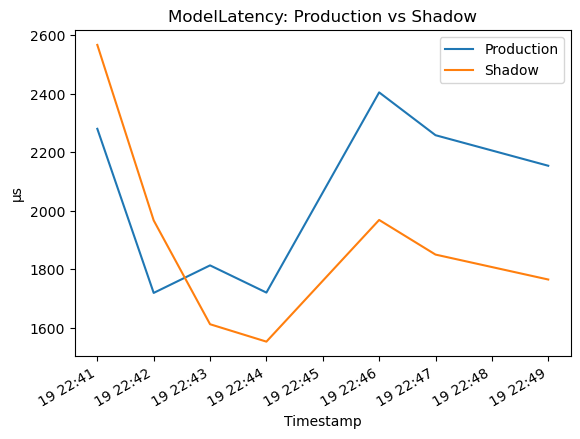

In [84]:
import pandas as pd

if prod_latency is not None and shadow_latency is not None:
    latency_comparison = pd.concat([prod_latency, shadow_latency], axis=1)
    latency_comparison.columns = ["Production", "Shadow"]
    latency_comparison.plot(title="ModelLatency: Production vs Shadow", ylabel="μs")
else:
    print("⚠️ No latency data available yet — wait 60s or ensure traffic is sent.")

In [85]:
# ⏰ Define time window (last 60 mins)
from datetime import datetime, timedelta, timezone
start_time = datetime.now(timezone.utc) - timedelta(minutes=60)
end_time = datetime.now(timezone.utc)

# ✅ Production Metrics
prod_latency = get_sagemaker_metrics(endpoint_name, None, "ProdVariant", "ModelLatency", "Average", start_time, end_time)
prod_5xx = get_sagemaker_metrics(endpoint_name, None, "ProdVariant", "Invocation5XXErrors", "Sum", start_time, end_time)

# ✅ Shadow Metrics
shadow_latency = get_sagemaker_metrics(endpoint_name, None, "ShadowVariant", "ModelLatency", "Average", start_time, end_time)
shadow_5xx = get_sagemaker_metrics(endpoint_name, None, "ShadowVariant", "Invocation5XXErrors", "Sum", start_time, end_time)


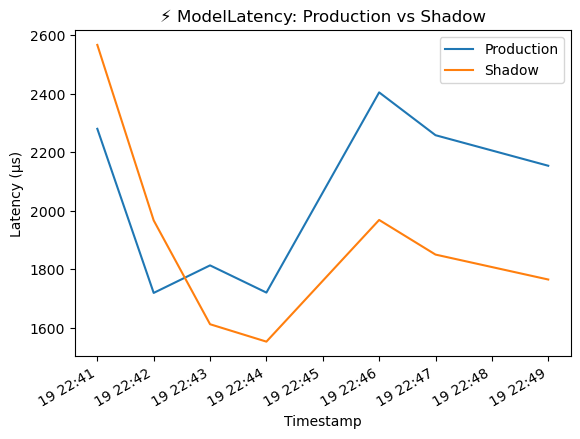

In [86]:
import pandas as pd

if prod_latency is not None and shadow_latency is not None:
    latency_comparison = pd.concat([prod_latency, shadow_latency], axis=1)
    latency_comparison.columns = ["Production", "Shadow"]
    latency_comparison.plot(title="⚡ ModelLatency: Production vs Shadow", ylabel="Latency (μs)")
else:
    print("⚠️ No latency data available yet — try resending test traffic.")


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/events.py:82: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


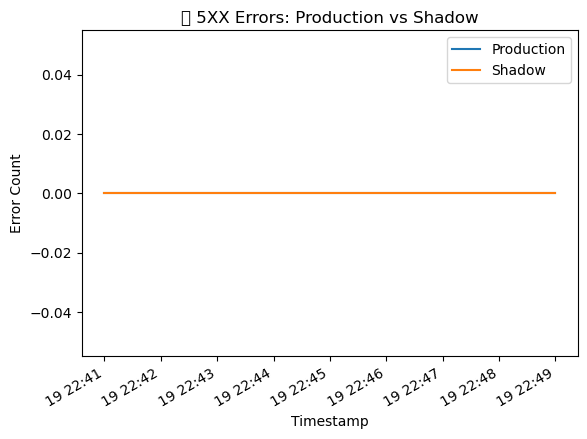

In [87]:
if prod_5xx is not None and shadow_5xx is not None:
    error_comparison = pd.concat([prod_5xx, shadow_5xx], axis=1)
    error_comparison.columns = ["Production", "Shadow"]
    error_comparison.plot(title="❌ 5XX Errors: Production vs Shadow", ylabel="Error Count")
else:
    print("⚠️ No 5XX error data available — all good or no traffic yet.")


# Cleanup <a id='Cleanup'></a>

If you do not plan to use this endpoint further, you should delete the endpoint to avoid incurring additional charges and clean up other resources created in this notebook.

In [92]:
sm.delete_endpoint(EndpointName=endpoint_name)

{'ResponseMetadata': {'RequestId': '9c0827f0-8d59-4df1-a2ba-56a00e463e4d',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '9c0827f0-8d59-4df1-a2ba-56a00e463e4d',
   'content-type': 'application/x-amz-json-1.1',
   'date': 'Sat, 19 Apr 2025 23:08:54 GMT',
   'content-length': '0'},
  'RetryAttempts': 0}}

In [ ]:
sm.delete_endpoint_config(EndpointConfigName=ep_config_name)
sm.delete_endpoint_config(EndpointConfigName=ep_config_name2)
sm.delete_endpoint_config(EndpointConfigName=ep_config_name3)

In [ ]:
sm.delete_model(ModelName=model_name)
sm.delete_model(ModelName=model_name2)
sm.delete_model(ModelName=model_name3)

In [ ]:
cw.delete_alarms(AlarmNames=[error_alarm, latency_alarm])